# CB data processing
## Xiaonan Wang
## 15May2020

In [2]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [3]:
# read in Kenny's dataset
CBdata_hvg = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/ycks3/laurenti/analysis_laurenti/serena/qa22_qa81_with_without_PD/combat_with_PD_FINAL_sizeNorm/umap_FDG_pseudotime_cellphase_timepoints_withPD/qa81_22_no48only_combat_noCovariate_sizeNorm_noregress_pca_dpt_umap_fa_cellphase.h5ad')

In [3]:
# read in raw counts
CBdata1 = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/ycks3/laurenti/analysis_laurenti/serena/qa22_qa81_no72PD/t_count_qa81_361.csv', cache=True)
CBdata2 = sc.read('/home/xw251/rds/rds-bg200-hphi-gottgens/users/ycks3/laurenti/analysis_laurenti/serena/qa22_qa81_no72PD/t_count_qa22_195.csv', cache=True)

... reading from cache file cache/home-xw251-rds-rds-bg200-hphi-gottgens-users-ycks3-laurenti-analysis_laurenti-serena-qa22_qa81_no72PD-t_count_qa81_361.h5ad
... reading from cache file cache/home-xw251-rds-rds-bg200-hphi-gottgens-users-ycks3-laurenti-analysis_laurenti-serena-qa22_qa81_no72PD-t_count_qa22_195.h5ad


In [4]:
# combine data
CBdata = CBdata1.concatenate(CBdata2)
CBdata.obs_names = [x[:-2] for x in CBdata.obs_names]
CBdata = CBdata[CBdata_hvg.obs_names, :].copy()
CBdata.obs = CBdata_hvg.obs

# read in feature table
ftable_loc = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/MPB1234/MPB_data/features.tsv'
ftable = pd.read_csv(ftable_loc, index_col = 0, header=None, delimiter='\t')
ftable = ftable.loc[CBdata.var_names, :].copy()
ftable.columns = ['Gene_Name', 'Gene_Biotype']
CBdata.var = ftable
CBdata.var['Ensembl_ID'] = CBdata.var_names
CBdata.var_names = CBdata.var['Gene_Name']
CBdata.var_names_make_unique()

# quick QC
sc.pp.filter_genes(CBdata, min_cells=1)
CBdata.var_names_make_unique()

filtered out 21890 genes that are detected in less than 1 cells


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculate SF for genes:
Filtered matrix shape: (536, 50)
Number of valid means:50
MeanForFit:  5
12211


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


Length of HVGs: 4739


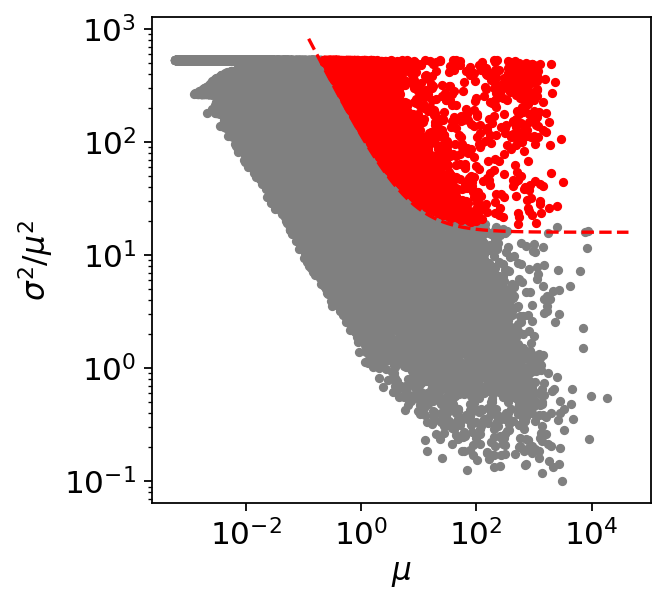

In [5]:
# here do a quick test on normalisation and HVG selection
CBdata_test = CBdata.copy()
smqpp.normalise_data(CBdata_test)
CBdata_test.raw = CBdata_test
smqpp.tech_var(CBdata_test, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(CBdata_test)

Now we see potential impacts of some outlier cells contributing to high mean and variance. (could be doublets?) This will effect the selection of highly variable genes, so we next try to find them out and remove them.

Number of selected Genes: 74
Number of outlier cell: 1
Outlier cells: ['SLX.14930.i708_i506']


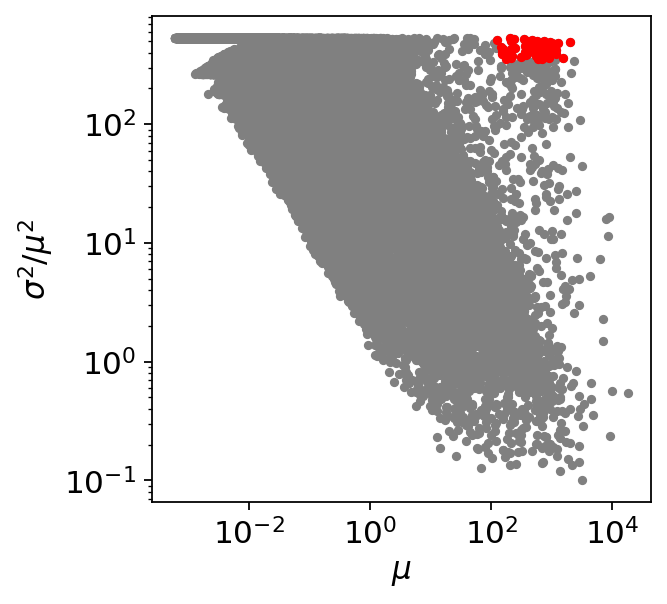

In [7]:
# Find outlier cells, we found one first, let's try to remove it
outlierC = smqpp.detect_outlier_cells(CBdata_test)

Calculate SF for genes:
Filtered matrix shape: (535, 58)
Number of valid means:58


/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:375: RuntimeWarning: invalid value encountered in true_divide
  cv2a = (aStd/aMean)**2
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/statsmodels/genmod/generalized_linear_model.py:278: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/smqpp/__init__.py:412: RuntimeWarning: divide by zero encountered in true_divide
  chi2_values = df * cv2s / (psi / sMean + a0)
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/xw251/miniconda

MeanForFit:  5
12137
Length of HVGs: 3342


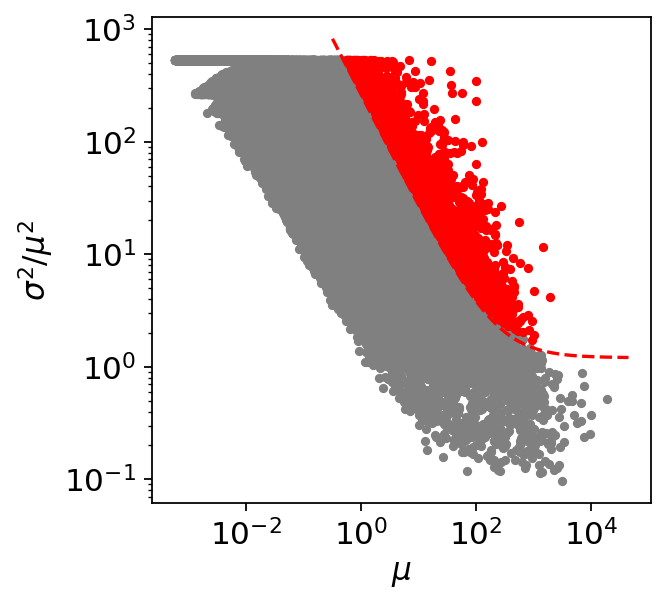

In [8]:
# Remove the outlier cell and run normalisation and HVG selection again
# and it worked! I don't have ERCC or QC data, so I just use the genes for HVG selection
CBdata = CBdata[CBdata.obs_names.values != outlierC, :].copy()
smqpp.normalise_data(CBdata)
CBdata.raw = CBdata
smqpp.tech_var(CBdata, useERCC=False, meanForFit=5) 
smqpp.plot_tech_var(CBdata)

In [9]:
# Only select the HVGs
CBdata = CBdata[:,CBdata.uns['varGenes']['genes']['highVar']].copy()

In [10]:
CBdata

AnnData object with n_obs × n_vars = 535 × 3342 
    obs: 'Average_Library_Length', 'CRI_identifier', 'CRI_run', 'Cell_type_general', 'Cell_type_subtype', 'ClusterCol', 'Details', 'FACs_index_data', 'FSC.A', 'FSC.W', 'ID', 'Index', 'Owner', 'Plate_number', 'Position_in_96_well_plate_RNA.seq', 'Position_in_96_well_plate_sorted', 'SSC.A', 'Sample_ID', 'Sample_name', 'Species', 'Time', 'batch', 'n_counts', 'dpt_pseudotime', 'ranking', 'new_index', 'S_score', 'G2M_score', 'phase', 'sf_gene'
    var: 'Gene_Name', 'Gene_Biotype', 'Ensembl_ID', 'n_cells'
    uns: 'varGenes'

In [11]:
# Scale the data for PCA then do other DR
sc.pp.scale(CBdata)
sc.tl.pca(CBdata, svd_solver='arpack')
sc.pp.neighbors(CBdata, n_neighbors=10)
sc.tl.umap(CBdata)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)


... storing 'Gene_Biotype' as categorical


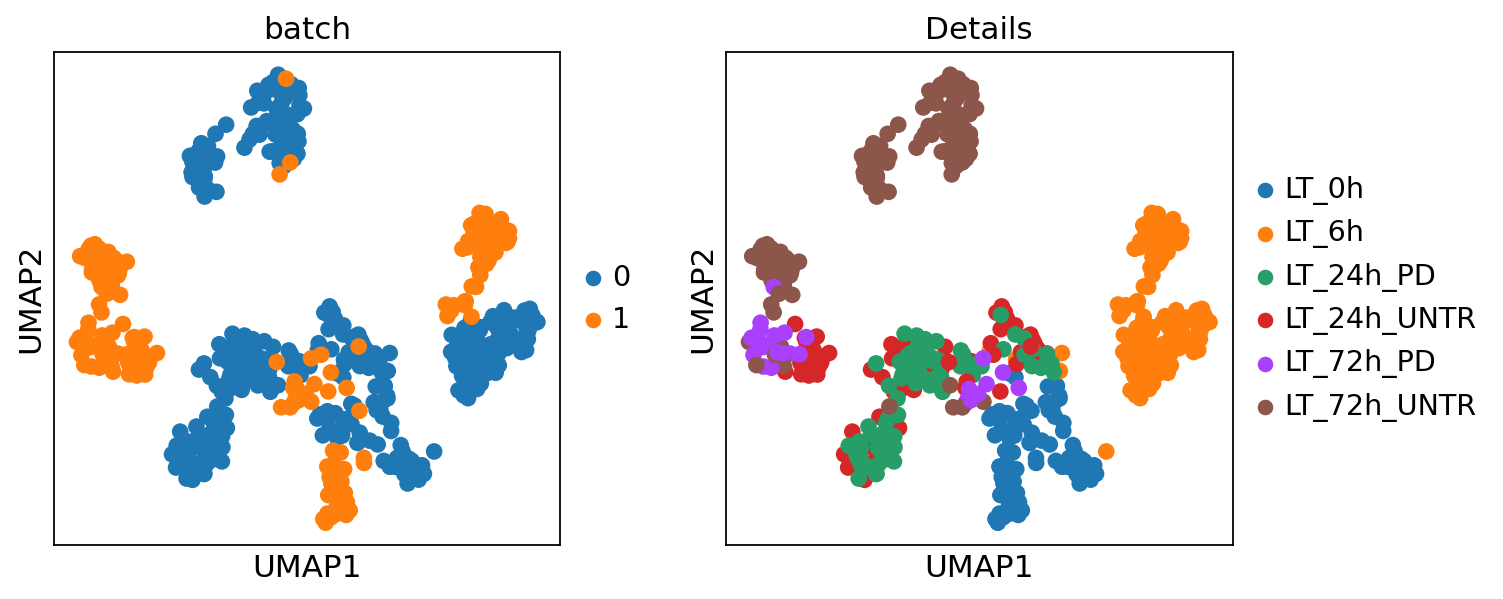

In [12]:
# We see batch effect here and needs to be removed
sc.pl.umap(CBdata, color=['batch','Details'])

In [13]:
CBdata.write('./write/CBdata_processed.h5ad')

... storing 'Gene_Name' as categorical
... storing 'Gene_Biotype' as categorical


As we need to do project, so we need batch corrected PCA, so this time I used fastMNN rather than bbknn.

In [14]:
# Batch correction using fastMNN in R (scanpy version somehow didnt work for my version of scanpy)
# But when they update again, could use their default in python
X_pca = CBdata.obsm['X_pca']
idx0 = CBdata.obs['batch'] == '0'
idx1 = CBdata.obs['batch'] == '1'
pca0 = pd.DataFrame(X_pca[idx0])
pca1 = pd.DataFrame(X_pca[idx1])

In [15]:
%reload_ext rpy2.ipython

In [16]:
%%R -i pca0 -i pca1 -o odf
suppressMessages(library("batchelor"))
odf = reducedMNN(data.matrix(pca0), data.matrix(pca1), 
                      BPPARAM=MulticoreParam(detectCores()))
odf = data.frame(odf$corrected)

In [17]:
CNs = np.concatenate([CBdata.obs_names[x] for x in [idx0, idx1]])
CBdata = CBdata[CNs,:].copy()
CBdata.obsm['X_pca'] = odf.values

In [18]:
# recalcualte everything for visualisation
sc.pp.neighbors(CBdata, n_neighbors=10)
sc.tl.diffmap(CBdata)
umap_ref = smqpp.quick_umap(CBdata)

# Save the root cells defined by Kenny
CBdata.uns['iroot']=np.where(CBdata.obs_names==CBdata_hvg.obs_names[CBdata_hvg.uns['iroot']])[0][0]
sc.tl.dpt(CBdata, n_branchings=1, n_dcs=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9915756  0.97888625 0.9636505  0.9377102  0.92483425
     0.87593246 0.86678374 0.8534594  0.8423739  0.79898614 0.754609
     0.7470742  0.73999965 0.7233108 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


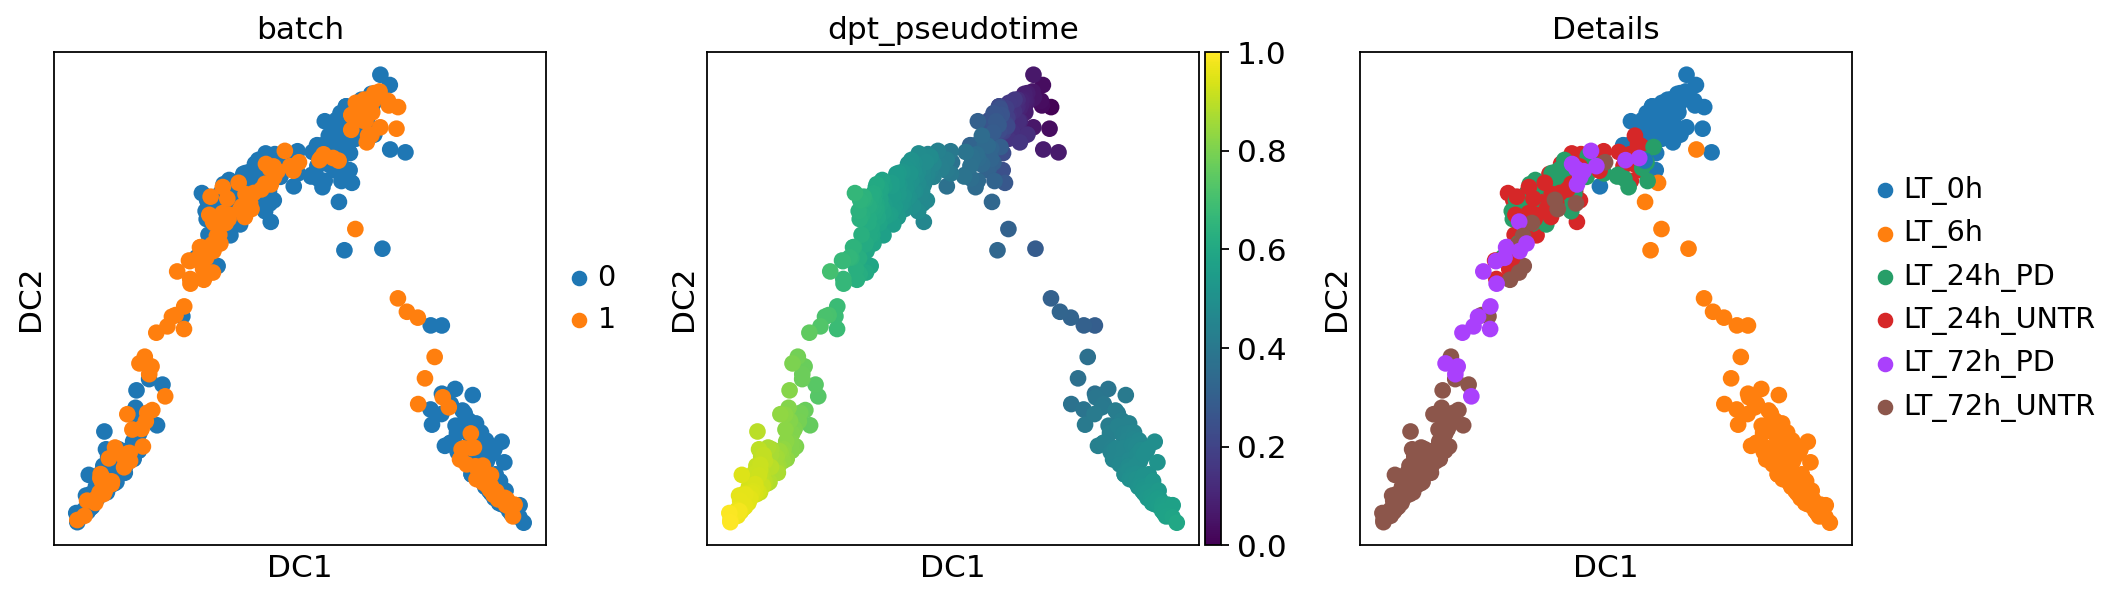

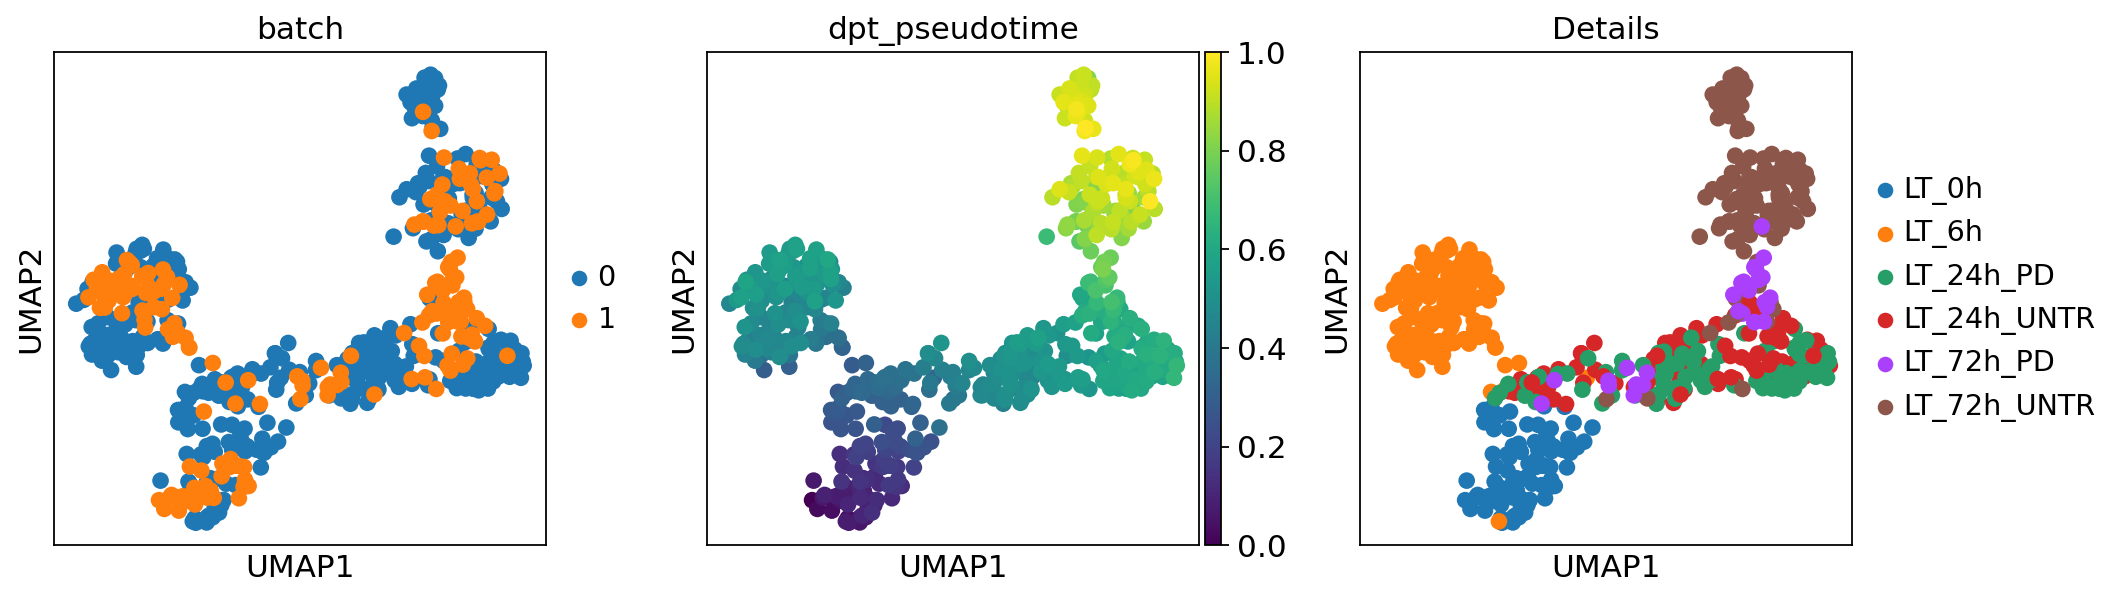

In [6]:
# just do it for CB data, looks fine
sc.pl.diffmap(CBdata, color=['batch', 'dpt_pseudotime', 'Details'])
sc.pl.umap(CBdata, color=['batch', 'dpt_pseudotime', 'Details'])

In [7]:
# Save the data and will be used later for projection
CBdata.write('./write/CBdata_processed_BC_fastMNN.h5ad')

In [22]:
# We need batch corrected PCA so not doing bbknn this time
# import bbknn
# CBdata_bbknn = bbknn.bbknn(CBdata, copy=True)
# sc.tl.umap(CBdata_bbknn)
# sc.tl.diffmap(CBdata_bbknn)
# sc.pl.umap(CBdata_bbknn, color=['batch','Details'])
# sc.pl.diffmap(CBdata_bbknn, color=['batch','Details'])
# CBdata_bbknn.write('./write/CBdata_processed_BC.h5ad')